In [60]:
import os;
import pandas as pd;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
files = os.listdir('data');
review_df = pd.read_csv(os.path.join('data/olist_order_reviews_dataset.csv'))
order_df = pd.read_csv(os.path.join('data/olist_orders_dataset.csv'))

df = pd.merge(review_df, order_df, on='order_id', how='left')
df.drop(columns=['review_id', 'order_id', 'customer_id', 'review_answer_timestamp'], inplace=True)

#Dropando linhas do dataset que não possuem título e comentário de review
df = df.dropna(subset=['review_comment_title', 'review_comment_message'], how='all')

# Converte para numérico, transformando valores inválidos em NaN
df["review_score"] = pd.to_numeric(df["review_score"], errors="coerce")

In [62]:
print(df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 42706 entries, 3 to 99223
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   review_score                   42706 non-null  int64 
 1   review_comment_title           11568 non-null  object
 2   review_comment_message         40977 non-null  object
 3   review_creation_date           42706 non-null  object
 4   order_status                   42706 non-null  object
 5   order_purchase_timestamp       42706 non-null  object
 6   order_approved_at              42601 non-null  object
 7   order_delivered_carrier_date   41497 non-null  object
 8   order_delivered_customer_date  40804 non-null  object
 9   order_estimated_delivery_date  42706 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.6+ MB
None


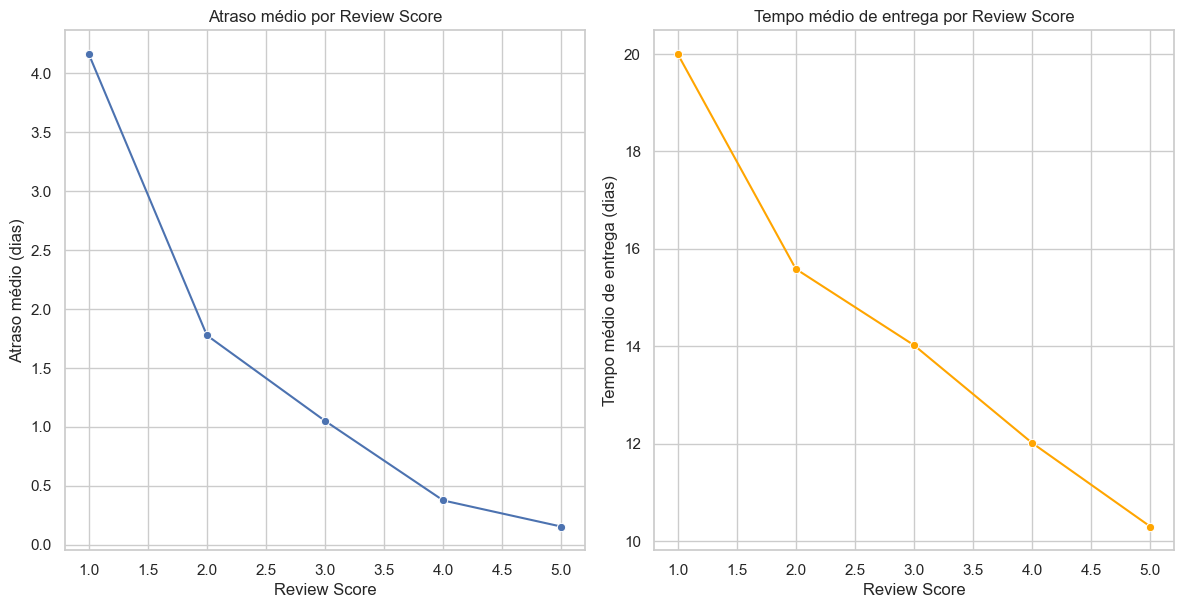

In [63]:
# Converter colunas de data
date_cols = [
    "order_purchase_timestamp", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date"
]

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Excluir linhas em que a entrega nunca aconteceu
df = df[df["order_delivered_customer_date"].notna()]

# Tempo entre compra e entrega (em dias)
df["delivery_time"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

# Tempo de atraso (entrega - estimativa)
df["delay_time"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["delay_time"] = df["delay_time"].clip(lower=0)  # força mínimo 0

# Média de atraso por review_score
delay_by_score = df.groupby("review_score")["delay_time"].mean().reset_index()

# Média de tempo de entrega por review_score
delivery_by_score = df.groupby("review_score")["delivery_time"].mean().reset_index()

# Configuração geral do Seaborn
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico 1 - Atraso médio
sns.lineplot(
    data=delay_by_score, 
    x="review_score", 
    y="delay_time", 
    marker="o", 
    ax=axes[0]
)
axes[0].set_title("Atraso médio por Review Score")
axes[0].set_xlabel("Review Score")
axes[0].set_ylabel("Atraso médio (dias)")
axes[0].set_box_aspect(1)

# Gráfico 2 - Tempo médio de entrega
sns.lineplot(
    data=delivery_by_score, 
    x="review_score", 
    y="delivery_time", 
    marker="o", 
    color="orange",
    ax=axes[1]
)
axes[1].set_title("Tempo médio de entrega por Review Score")
axes[1].set_xlabel("Review Score")
axes[1].set_ylabel("Tempo médio de entrega (dias)")
axes[1].set_box_aspect(1)

plt.tight_layout()
plt.show()


## Grafico plotados

In [64]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('portuguese'))

def limpar_texto(texto):
    # converte para minúsculas
    texto = texto.lower()
    # remove espaços extras
    texto = texto.strip()
    texto = " ".join(texto.split())
    
    # remove URLs e e-mails
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"\S+@\S+", "", texto)
    
    # remove números
    texto = re.sub(r"\d+", "", texto)
    
    # remove emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
        u"\U0001F680-\U0001F6FF"  # transporte e símbolos
        u"\U0001F1E0-\U0001F1FF"  # bandeiras (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    texto = emoji_pattern.sub(r'', texto)
    
    # remove caracteres especiais mantendo letras e pontuação básica
    texto = re.sub(r"[^a-zA-ZÀ-ú\s!?]", "", texto)
    
    # normaliza acentos
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    
    # remove stopwords
    texto = " ".join([w for w in texto.split() if w not in stop_words])
    
    return texto

In [65]:
# Ler lexicon do txt
lex = pd.read_csv(
    "dict/lexico_v3.0.txt",
    sep=",",
    header=None,
    names=["word", "pos", "polarity", "tag"]
)

# Garantir que a polaridade é numérica
lex["polarity"] = pd.to_numeric(lex["polarity"], errors="coerce")

# Separar duplicadas
duplicadas = lex[lex.duplicated(subset="word", keep=False)]

# Função para manter manual se existir, senão primeira automática
def escolher(row_group):
    manuais = row_group[row_group["tag"] == "M"]
    if not manuais.empty:
        return manuais.iloc[0]  # mantém a primeira manual
    else:
        return row_group.iloc[0]  # mantém a primeira automática

# Aplicar por palavra
lex_clean = duplicadas.groupby("word", group_keys=False).apply(escolher)

# Adicionar palavras não duplicadas
lex_unique = lex[~lex["word"].isin(duplicadas["word"])]
lex_final = pd.concat([lex_unique, lex_clean], ignore_index=True)

# Criar dicionário final
lexicon = lex_final.set_index("word")[["polarity", "tag"]].to_dict(orient="index")

# Função de sentimento
def sentimento_oplexicon(texto):
    texto = limpar_texto(texto)  # função que você já tem
    tokens = texto.split()
    score = 0
    for token in tokens:
        if token in lexicon:
            pol = lexicon[token]["polarity"]
            tag = lexicon[token]["tag"]
            peso = 1.0 if tag == "M" else 0.9  # maior peso para revisadas manualmente
            score += pol * peso
    if len(tokens) == 0:
        return 0
    return max(min(score / len(tokens), 1), -1)

C:\Users\alanm\AppData\Local\Temp\ipykernel_3740\1498865228.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lex_clean = duplicadas.groupby("word", group_keys=False).apply(escolher)


In [66]:
# Aplica a função de limpeza nas colunas de título e comentário do review
df['review_comment_message'] = df['review_comment_message'].apply(lambda x: limpar_texto(str(x)) if pd.notnull(x) else x)
df['review_comment_title'] = df['review_comment_title'].apply(lambda x: limpar_texto(str(x)) if pd.notnull(x) else x)

# Definicoes das funcoes de target

In [67]:
#Atraso de entrega (estimado - entregue)
def target_3(row):
    delivered = row.get("order_delivered_customer_date", None)
    estimated = row.get("order_estimated_delivery_date", None)
    if pd.isna(delivered) or pd.isna(estimated):
        return 0
    try:
        atraso = (pd.to_datetime(delivered) - pd.to_datetime(estimated)).days
        # Normalizar atraso para [-1, 1]
        if atraso <= -5:  # Muito antecipado
            return 1
        elif atraso <= 0:  # No prazo ou antecipado
            return 0.5
        elif atraso <= 3:  # Pequeno atraso
            return 0
        elif atraso <= 10:  # Atraso médio
            return -0.5
        else:  # Atraso grande (>10 dias)
            return -1
    except:
        return 0

"""
A hipótese inicial era utilizar o tempo de entrega total, mas como a relação com as avaliações é linear, utilizar ambas as métricas não adiciona valor.

Tempo total de entrega (compra até entrega)
def target_4(row):
    purchased = row.get("order_purchase_timestamp", None)
    delivered = row.get("order_delivered_customer_date", None)
    if pd.isna(purchased) or pd.isna(delivered):
        return 0
    try:
        dias = (pd.to_datetime(delivered) - pd.to_datetime(purchased)).days
        if dias < 0:  # Dados inconsistentes
            return 0
        elif dias <= 5:  # Muito rápido
            return 1
        elif dias <= 10:  # Rápido
            return 0.5
        elif dias <= 20:  # Normal
            return 0
        elif dias <= 35:  # Lento
            return -0.5
        else:  # Muito lento (>35 dias)
            return -1
    except:
        return 0
"""

#Contradição entre review_score e entrega
def target_5(row):
    score_norm = row.get("target_1", 0)
    
    # Calcular atraso
    delivered = row.get("order_delivered_customer_date", None)
    estimated = row.get("order_estimated_delivery_date", None)
    atraso = 0
    if not pd.isna(delivered) and not pd.isna(estimated):
        try:
            atraso = (pd.to_datetime(delivered) - pd.to_datetime(estimated)).days
        except:
            atraso = 0
    
    # Detectar contradições
    if score_norm > 0.5 and atraso > 10:  # Nota alta + grande atraso
        return -0.5
    elif score_norm < -0.5 and atraso <= 0:  # Nota baixa + entrega antecipada
        return -0.3
    elif score_norm > 0 and atraso > 20:  # Nota positiva + atraso muito grande
        return -0.7
    elif score_norm < 0 and atraso <= -3:  # Nota negativa + entrega muito antecipada
        return -0.4
    else:
        return 0

# 6. Qualidade do comentário (tamanho do texto)
def target_6(row):
    texto = str(row.get("texto"))
    try:
        # Se existe função limpar_texto, usar ela
        if 'limpar_texto' in globals():
            texto = limpar_texto(texto)
        
        length = len(texto.split()) if texto and texto.strip() else 0
        
        if length == 0:  # Sem comentário
            return -0.3
        elif length == 1:  # Muito curto (1 palavra)
            return -0.2
        elif length <= 3:  # Curto (2-3 palavras)
            return -0.1
        elif length <= 10:  # Médio (4-10 palavras)
            return 0.2
        elif length <= 30:  # Bom (11-30 palavras)
            return 0.5
        else:  # Muito detalhado (>30 palavras)
            return 1
    except:
        return 0

In [68]:
df["texto"] = df["review_comment_title"].fillna("") + " " + df["review_comment_message"].fillna("")

# Aplicando os targets no DataFrame

#Normalização da nota de review entre 1 e 5 para -1 a 1
df["target_1"] = (df["review_score"] - 3) / 2

# Sentimento do texto (título + mensagem)
df["target_2"] = df["texto"].apply(sentimento_oplexicon)

# Atraso de entrega
df["target_3"] = df.apply(target_3, axis=1)

# Tempo total de entrega
#df["target_4"] = df.apply(target_4, axis=1)

# Contradição entre review_score e entrega
df["target_5"] = df.apply(target_5, axis=1)

# Qualidade do comentário
df["target_6"] = df.apply(target_6, axis=1)

# Score final ponderado
df["final_score"] = (
    0.45 * df["target_1"] +  # nota do review continua importante
    0.35 * df["target_2"] +  # comentário textual tem grande influência
    0.15 * df["target_3"] +  # atraso
    #0.05 * df["target_4"] +  # O peso do tempo total de entrega foi removido e distribuído para outras métricas
    0.03 * df["target_5"] +  # contradições
    0.02 * df["target_6"]    # tamanho do comentário
).clip(-1, 1)

df["categorical_score"] = 1

df.loc[df["final_score"] < 0, "categorical_score"] = 0
df.loc[df["final_score"] > 0, "categorical_score"] = 1




In [69]:
# treina em 70% e testa em 30%
# usar cross validation
# fazer  o fit do modelo
# model.fit(X, y)

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Separar features e target
X = df[["target_1", "target_2", "target_3", "target_5", "target_6"]]
y = df["categorical_score"]  # NEGATIVO -> 0, POSITIVO -> 1

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar modelo
model = XGBClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    eval_metric="mlogloss"
)

model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular acurácia
acc = accuracy_score(y_test, y_pred)
print("Acurácia:", acc)

# Relatório detalhado
print(classification_report(y_test, y_pred))

Acurácia: 0.9986113380166639
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2929
           1       1.00      1.00      1.00      9313

    accuracy                           1.00     12242
   macro avg       1.00      1.00      1.00     12242
weighted avg       1.00      1.00      1.00     12242



In [70]:
# Cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print("Acurácia média CV:", scores.mean())
print("Desvio padrão CV:", scores.std())

Acurácia média CV: 0.9993628111702959
Desvio padrão CV: 0.00026165427832556897


In [ ]:
import spacy
from gensim.models import FastText
from collections import defaultdict
import pandas as pd
import numpy as np

nlp = spacy.load("pt_core_news_sm")

# Preprocessamento e tokenização
def preprocess(text):
    doc = nlp(str(text).lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

df["tokens"] = df["texto"].apply(preprocess)
tokenized_reviews = df["tokens"].tolist()

# Treinar FastText
ft_model = FastText(
    sentences=tokenized_reviews,
    vector_size=50,
    window=3,
    min_count=1,
    epochs=10
)


# Dicionário de categorias e sinônimos
categories_synonyms = {
    "entrega": [
        "entrega", "entregue", "entregaram", "entregando", "entregou",
        "chegou", "chegada", "chegar", "prazo", "pontual", "antecedência",
        "antes do prazo", "super rapida", "super rapido", "demorou", "demora", 
        "atraso", "atrasada", "atrasou", "enviado", "envio", "remessa", 
        "transportadora", "frete", "despacho", "dividida", "demorou pra entrega",
        "nao recebi", "faltou entrega", "ainda nao chegou", "demorou postar"
    ],

    "qualidade": [
        "qualidade", "produto", "bom", "boa", "ótimo", "otimo", "excelente",
        "perfeito", "show", "top", "maravilhoso", "maravilha", "lindo",
        "durável", "durabilidade", "material", "acabamento", "funciona",
        "funcional", "eficiente", "resistente", "desempenho", "confiavel",
        "estragado", "quebrado", "danificado", "defeito", "ruim", "péssimo",
        "pessimo", "inferior", "falso", "original", "autentico", "nao funciona",
        "travando", "nao condiz", "manual", "nao reconheceu", "peca nao serviu",
        "pecas nao encaixava", "inferior", "bonito", "mal acabado"
    ],

    "atendimento": [
        "atendimento", "suporte", "ajuda", "assistência", "resposta",
        "responderam", "educado", "gentil", "cordial", "educação", "prestativo",
        "contato", "comunicação", "vendedor", "lojista", "sac", "call center",
        "ouvidoria", "parceria", "solução", "demorado", "ignorado",
        "nao houve retorno", "dificil contato", "nao recomendo loja",
        "parabens loja", "otima loja"
    ],

    "preço": [
        "preço", "valor", "custo", "custobeneficio", "custo-benefício",
        "caro", "caríssimo", "carissima", "barato", "barata", "baratinho",
        "em conta", "acessível", "promoção", "oferta", "desconto",
        "economia", "vale a pena", "pagamento", "paguei", "pagando", "custou",
        "gratuito", "frete grátis", "frete caro", "custo frete", "azedo"
    ],

    "embalagem": [
        "embalagem", "embalado", "embalaram", "pacote", "caixa", "caixinha",
        "sacola", "envelope", "proteção", "plastificado", "plástico bolha",
        "involucro", "lacrado", "lacração", "bem protegido", "mal embalado",
        "rasgado", "amassado", "danificado", "seguro", "preservado",
        "vidro quebrado", "nenhuma protecao", "bem embalados", "protegido"
    ],
    "disponibilidade": [
        "faltando", "faltou produto", "não recebi", "ainda não recebi", 
        "apenas", "parcial", "mandei dois emails", "nao chegou", "aguardo solucao",
        "recebi somente", "apenas pecas", "nao entregue", "parcelado", "recebi tarde"
    ],

    "funcionamento": [
        "não funciona", "nao funciona", "erro", "não reconheceu", "nao reconheceu",
        "sincronismo", "incompatível", "não condiz", "travando", "peca nao serviu",
        "mal acabado", "defeito tecnico", "problemas", "problema"
    ],

    "experiencia_compra": [
        "processo compra", "tranquilo", "facil", "rapido", "rápido", "fácil",
        "site", "nota", "pedido realizado", "pagamento", "compra realizada",
        "nota interna", "internet", "online", "checkout", "pedido certo"
    ],

    "satisfacao_geral": [
        "super recomendo", "maravilhoso", "maravilha", "top", "adorei", 
        "excelente loja", "otimo", "ótimo", "bom", "boa", "show", "recomendo sempre",
        "feliz", "agradavel", "satisfeito", "obrigado"
    ]
}

# Função de similaridade
def cosine_sim(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-8)

def score_category(tokens, threshold=0.3):
    scores = defaultdict(float)

    for token in tokens:
        lemma = token.lower()

        # 1) Match direto no dicionário
        for cat, synonyms in categories_synonyms.items():
            if lemma in synonyms:
                scores[cat] += 1.5

        # 2) Similaridade semântica
        if lemma in ft_model.wv:
            for cat, synonyms in categories_synonyms.items():
                sims = [
                    cosine_sim(ft_model.wv[lemma], ft_model.wv[syn]) 
                    for syn in synonyms if syn in ft_model.wv
                ]
                if sims:
                    max_sim = max(sims)
                    if max_sim >= threshold:
                        scores[cat] += max_sim

    return dict(scores)


df["category_scores"] = df["tokens"].apply(score_category)

# Categoria dominante = motivo principal
df["main_category"] = df["category_scores"].apply(
    lambda x: max(x, key=x.get) if x else None
)


In [72]:
print(df.columns);

Index(['review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time', 'delay_time', 'texto', 'target_1', 'target_2',
       'target_3', 'target_5', 'target_6', 'final_score', 'categorical_score',
       'tokens', 'category_scores', 'main_category'],
      dtype='object')


In [ ]:
# Templates personalizados por categoria
templates = {
    "entrega": {
        0: "críticas ao prazo de entrega",
        1: "elogios ao prazo de entrega"
    },
    "qualidade": {
        0: "críticas à qualidade do produto",
        1: "elogios à qualidade do produto"
    },
    "atendimento": {
        0: "críticas ao atendimento",
        1: "elogios ao atendimento"
    },
    "preço": {
        0: "críticas ao preço",
        1: "elogios ao preço"
    },
    "embalagem": {
        0: "críticas à embalagem",
        1: "elogios à embalagem"
    },
    "disponibilidade": {
        0: "críticas à disponibilidade do produto",
        1: "elogios à disponibilidade do produto"
    },
    "funcionamento": {
        0: "críticas ao funcionamento do produto",
        1: "elogios ao funcionamento do produto"
    },
    "experiencia_compra": {
        0: "críticas à experiência de compra",
        1: "elogios à experiência de compra"
    },
    "satisfacao_geral": {
        0: "críticas gerais",
        1: "elogios gerais"
    }
}

def gerar_motivo(row):
    sentimento = row["categorical_score"]
    categoria = row["main_category"]

    if pd.isna(categoria):
        return None

    if categoria in templates and sentimento in templates[categoria]:
        return templates[categoria][sentimento]
    return None

# Criar coluna final
df["motivo_avaliacao"] = df.apply(gerar_motivo, axis=1)


# Converter categorical_score em rótulo
map_sentimento = {0: "negativo", 1: "positivo"}
df["sentimento"] = df["categorical_score"].map(map_sentimento)

# Salvar
df.drop(columns=["categorical_score","target_1","target_2","target_3","target_5","target_6","final_score","tokens","main_category", "category_scores", "main_category"], inplace=True)
df.to_csv("cache/analysis_df.csv", index=False, sep=";")
